In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, Masking
from tqdm import tqdm
from transformers import XLNetTokenizer

import concurrent.futures
from concurrent.futures import ThreadPoolExecutor, as_completed

import joblib  # Para guardar y cargar archivos binarios
import os
import math
import json

##Datos

In [ ]:
df = pd.read_csv("/content/data_limpia_NV.csv", encoding='latin-1')
df = df.dropna()

In [ ]:
df['reviewText'] = df['reviewText'].astype('string')
df['rating'] = df['rating'].astype('int')

In [ ]:
# sparamos los rating con 0 menores iguales a 3 y con 1 mayores a 3
df['rating'].value_counts()

,count
rating,
5,64110
4,19357
3,8755
2,4151
1,3480


In [ ]:
df.loc[df['rating'] < 3, 'rating'] = 0
df.loc[df['rating'] == 3, 'rating'] = 1
df.loc[df['rating'] > 3, 'rating'] = 2

In [ ]:
df['rating'].value_counts()

,count
rating,
2,83467
1,8755
0,7631


In [ ]:
# Separamos la data en train y test y Val
X = df[['reviewText']]
y = df[['rating']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2 ,random_state=1, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5 ,random_state=1, stratify=y_val)

##Modelo XLNet

In [ ]:
# p = 1000

In [ ]:
# Cargar el tokenizer de XLNet
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

# Tokenizar los comentarios
def tokenize_data(comments):
    return tokenizer(comments, padding=True, truncation=True, max_length=128, return_tensors="pt")

# Aplicar el tokenizer a los comentarios
encodings = tokenize_data(df['reviewText'].astype(str).values.tolist())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
import torch
from sklearn.model_selection import train_test_split

# Convertir las etiquetas a tensores
labels = torch.tensor(df['rating'].values)

# # Dividir en entrenamiento y prueba
X_train, X_val, y_train, y_val = train_test_split(encodings['input_ids'], labels, test_size=0.2 ,random_state=1, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5 ,random_state=1, stratify=y_val)


In [ ]:
from torch.utils.data import DataLoader, TensorDataset
from transformers import AdamW

# Crear el dataset
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=8)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=8)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=8)

In [ ]:
from sklearn.metrics import accuracy_score
from transformers import XLNetForSequenceClassification
from transformers import AdamW
import torch

class ModelXNet:

    model = None
    cant_epoch = 3

    def __init__(self):
        # Cargar el modelo XLNet preentrenado para clasificación
        self.model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=3)
        self.optimizer = AdamW(self.model.parameters(), lr=5e-5)

        # Mover el modelo a la GPU si está disponible
        self._device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.model.to( self._device)

        self.tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

        # Inicializar listas para almacenar métricas de cada época
        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []

    def cargar_modelo(self, ruta_path):
        checkpoint_path = ruta_path # Ruta del archivo guardado
        checkpoint = torch.load(checkpoint_path)
        self.model.load_state_dict(checkpoint['model_state_dict'])

    def guardar_modelo(self, output_dir, name = "model_XNet_final"):
        # Guardar el modelo al final de cada época
        checkpoint_path = os.path.join(output_dir, f"{name}.pt")
        torch.save({
            'epoch': self._epoch + 1,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'loss': self._avg_train_loss,
            'val_loss': self._avg_val_loss,
            'accuracy': self._accuracy,
        }, checkpoint_path)
        print(f"Modelo guardado en {checkpoint_path}")

    def entrenar_modelo(self, train_data, val_data ,skip = 0):

        for epoch in range(self.cant_epoch):  # Número de épocas
            if epoch < skip:
                continue
            self.model.train()
            self._epoch = epoch
            # Entrenamiento
            total_loss = 0
            print(f"Época {epoch + 1}")

            # Barra de progreso para el entrenamiento
            for batch in tqdm(train_data, desc="Entrenamiento", leave=False):
                input_ids,  labels = [item.to(self._device) for item in batch]

                # Adelante
                outputs = self.model(input_ids, labels=labels)
                loss = outputs.loss
                total_loss += loss.item()

                # Atrás
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

            self._avg_train_loss = total_loss / len(train_data)  # Pérdida promedio en entrenamiento
            self.train_losses.append(self._avg_train_loss)
            print(f'Pérdida en entrenamiento en la época {epoch + 1}: {self._avg_train_loss}')

            self.validar_data(val_data)

    def validar_data(self, val_dat, val = True):
        # Evaluación en el conjunto de validación
        self.model.eval()  # Cambia el modelo a modo evaluación
        val_loss = 0
        predictions = []
        true_labels = []

        # Barra de progreso para la validación
        with torch.no_grad():  # Desactiva el cálculo de gradientes para validación
            for batch in tqdm(val_dat, desc="Validación", leave=False):
                input_ids, labels = [item.to(self._device) for item in batch]

                outputs = self.model(input_ids, labels=labels)
                loss = outputs.loss
                val_loss += loss.item()

                # Obtener las predicciones
                logits = outputs.logits
                preds = torch.argmax(logits, dim=1)
                predictions.extend(preds.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())

        # Calcular precisión (accuracy)
        self._avg_val_loss = val_loss / len(val_dat)  # Pérdida promedio en validación
        self._accuracy = accuracy_score(true_labels, predictions)
        if val:
          self.val_losses.append(self._avg_val_loss)  # Guardar pérdida de validación
          self.val_accuracies.append(self._accuracy)
          print(f'Pérdida en validación en la época {self._epoch + 1}: {self._avg_val_loss}')
          print(f'Precisión en validación en la época {self._epoch + 1}: {self._accuracy:.4f}')
        else:
          print()
          print(f'Precisión en Test: {self._accuracy:.4f}')

    def mostrar_graficos(self):
        # Graficar pérdida y precisión
        plt.figure(figsize=(12, 5))

        # Gráfico de pérdida
        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label='Pérdida de Entrenamiento')
        plt.plot(self.val_losses, label='Pérdida de Validación')
        plt.xlabel('Época')
        plt.ylabel('Pérdida')
        plt.title('Pérdida por Época')
        plt.legend()

        # Gráfico de precisión
        plt.subplot(1, 2, 2)
        plt.plot(self.val_accuracies, label='Precisión de Validación', color='orange')
        plt.xlabel('Época')
        plt.ylabel('Precisión')
        plt.title('Precisión por Época')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def evaluar_texto(self, texto):
        # Tokenizar el texto
        inputs = self.tokenizer(texto, return_tensors="pt", max_length=128, truncation=True, padding="max_length")
        inputs = {key: value.to(self._device) for key, value in inputs.items()}

        # Configurar el modelo en modo evaluación
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(**inputs)
            logits = outputs.logits
            pred = torch.argmax(logits, dim=1).cpu().item()

        # Decodificar la clase de la predicción
        if pred == 2:
            return "Positivo"
        elif pred == 1:
            return "Neutro"
        else:
            return "Negativo"


In [ ]:
model_xnet = ModelXNet()

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://gith

In [ ]:
model_xnet.entrenar_modelo(train_loader, val_loader)

Época 1


Pérdida en entrenamiento en la época 1: 0.5697554096164719


Pérdida en validación en la época 1: 0.5656362174390506
Precisión en validación en la época 1: 0.8360
Época 2


Pérdida en entrenamiento en la época 2: 0.5670429399118033


Pérdida en validación en la época 2: 0.5637900996580422
Precisión en validación en la época 2: 0.8360
Época 3


Pérdida en entrenamiento en la época 3: 0.5663023935360455


Pérdida en validación en la época 3: 0.562368749021243
Precisión en validación en la época 3: 0.8360


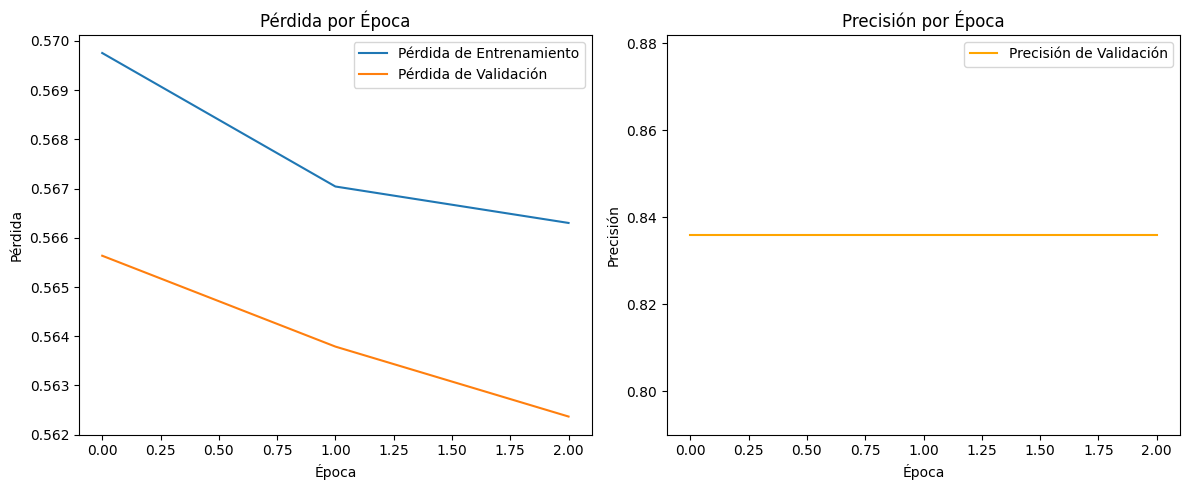

In [ ]:
model_xnet.mostrar_graficos()

In [ ]:
output_dir = "/content/drive/MyDrive/Proyecto-Tesis/Scripts/Adicionales/Modelo_XNet"
model_xnet.guardar_modelo(output_dir, name = f"modelo_XNet")

Modelo guardado en /content/drive/MyDrive/Proyecto-Tesis/Scripts/Adicionales/Modelo_XNet/modelo_XNet.pt


In [ ]:
# TEST
model_xnet.validar_data(test_loader)

Pérdida en validación en la época 3: 0.5626203431020841
Precisión en validación en la época 3: 0.8359


In [ ]:
model_xnet_aux = ModelXNet()
ruta_model = "/content/drive/MyDrive/Proyecto-Tesis/Scripts/Adicionales/Modelo_XNet/modelo_XNet.pt"
model_xnet_aux.cargar_modelo(ruta_model)

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://gith

In [ ]:
examples = [
    'this is such an amazing movie!',
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

for text in examples:

  reloaded_results = model_xnet_aux.evaluar_texto(text)
  original_results = model_xnet.evaluar_texto(text)

  print('Results from the saved model     :',text, reloaded_results)
  print('Results from the model in memory :',text, original_results)
  print()



Results from the saved model     : this is such an amazing movie! Positivo
Results from the model in memory : this is such an amazing movie! Positivo

Results from the saved model     : The movie was great! Positivo
Results from the model in memory : The movie was great! Positivo

Results from the saved model     : The movie was meh. Positivo
Results from the model in memory : The movie was meh. Positivo

Results from the saved model     : The movie was okish. Positivo
Results from the model in memory : The movie was okish. Positivo

Results from the saved model     : The movie was terrible... Positivo
Results from the model in memory : The movie was terrible... Positivo

